# Neural Thompson Sampling

<img src="./Figure/algorithm1.png" style="zoom:80%" />

<img src="./Figure/Loss_Function.png" style="zoom:80%" />

This paper prove the bound of expected regret bound, but it directly apply its algorithm on the classification problem, without a testing on online learning theorem.

It might be quite hard to compare its performance on online learning theory.

we set the real reward := 2 * np.exp(A^T context) / (1 + np.exp(A^T context)) - 1 + np.random.normal(loc=0, scale=1)

In [1]:
%reset -f
import numpy as np
import random
from copy import deepcopy
from GameSetting import *
from NeuralNetworkRelatedFunction import *

In [2]:
class NeuralAgent:
    def __init__(self, K, T, d, L = 2, m = 20, v = 0.1, lambda_ = 0.01, eta = 0.001, 
                 frequency = 50, batchsize = None, verbose = True):
        # K is Total number of actions,
        # T is Total number of periods
        # d is the dimension of context
        # L is the number of hidden layer
        # m is the number of neurals in each layer
        # the definition of v, lambda_, eta can be found on the original paper
        # frequency is the gap between neighbour training epoch
        # batchsize is the size of sample batch in SGD
        # verbose control whether print the traning detail
        self.K = K
        self.T = T
        self.d = d
        
        self.L = L
        self.m = m
        self.v = v
        self.lambda_ = lambda_
        self.eta = eta
        self.frequency = frequency # we train the network after frequency, e.g. per 50 round
        self.batchsize = batchsize
        self.verbose = verbose
        self.t = 0 # marks the index of period
        self.history_reward = np.zeros(T)
        self.history_action = np.zeros(T)
        self.predicted_reward = np.zeros(T)
        self.history_context = np.zeros((d, T))
        
        # initialize the value of parameter
        np.random.seed(12345)
        self.theta_0 = {}
        W = np.random.normal(loc = 0, scale = 4 / m, size=(int(m/2), int(m/2)))
        w = np.random.normal(loc = 0, scale = 2 / m, size=(1, int(m/2)))
        for key in range(1, L + 1):
            if key == 1:
                # this paper doesn't present the initialization of w1
                # in its setting, d = m, then he let theta_0["w1"]=[W,0;0,W]
                # but in fact d might not equal to m
                tempW = np.random.normal(loc = 0, scale = 4 / m, size=(int(m/2), int(d/2)))
                self.theta_0["w1"] = np.zeros((m, d))
                self.theta_0["w1"][0:int(m/2), 0:int(d/2)] = tempW
                self.theta_0["w1"][int(m/2):, int(d/2):] = tempW
            elif 2 <= key and key <= L - 1:
                self.theta_0["w" + str(key)] = np.zeros((m, m))
                self.theta_0["w" + str(key)][0:int(m/2), 0:int(m/2)] = W
                self.theta_0["w" + str(key)][int(m/2):, int(m/2):] = W
            else:
                self.theta_0["w" + str(key)] = np.concatenate([w, -w], axis = 1)
                
        self.p = m + m * d + m * m * (L - 2)
        self.params = deepcopy(self.theta_0)
        self.U = lambda_ * np.eye(self.p)
        self.params_history = {}
        self.grad_history = {}
    
    def Action(self, context_list):
        # context_list is a d*K matrix, each column represent a context
        # the return value is the action we choose, represent the index of action, is a scalar
        sample_estimated_reward = np.zeros(K) # the upper bound of K actions
        predict_reward = np.zeros(K)
        U_inverse = np.linalg.inv(self.U)
        for a in range(1, K + 1):
            predict_reward[a - 1] = NeuralNetwork(context_list[:, a - 1], self.params, self.L, self.m)['x' + str(self.L)][0]
            grad_parameter = GradientNeuralNetwork(context_list[:, a - 1], self.params, self.L, self.m)
            grad_parameter = FlattenDict(grad_parameter, self.L)
            sigma_square = self.lambda_ * grad_parameter.dot(U_inverse).dot(grad_parameter) / self.m
            sigma = np.sqrt(sigma_square)
            
            sample_estimated_reward[a - 1] = np.random.normal(loc = predict_reward[a - 1], scale = self.v * sigma)
            
        ind = np.argmax(sample_estimated_reward, axis=None)
        self.predicted_reward[self.t] = sample_estimated_reward[ind]
        self.history_action[self.t] = ind
        self.history_context[:, self.t] = context_list[:, ind]
        return ind
    
    def Update(self, reward):
        # reward is the realized reward after we adopt policy, a scalar
#         print("round {:d}".format(self.t))
        self.history_reward[self.t] = reward
        ind = self.history_action[self.t]
        context = self.history_context[:, self.t]
        
        # compute Z_t_minus1
        grad_parameter = GradientNeuralNetwork(context, self.params, self.L, self.m)
        grad_parameter = FlattenDict(grad_parameter, self.L)
        grad_parameter = np.expand_dims(grad_parameter, axis = 1)
        self.U = self.U + grad_parameter.dot(grad_parameter.transpose()) / self.m

        # train neural network
        if self.t % self.frequency == 0 and self.t > 0:
            J = self.t
        else:
            J = 0
            
        if self.batchsize == None:
            trainindex = range(0, self.t + 1)
        else:
            if self.batchsize > self.t + 1:
                trainindex = range(0, self.t + 1)
            else:
                trainindex = random.sample(range(0, self.t + 1), self.batchsize)
                
        grad_loss = {}
        for j in range(J):
            
            grad_loss = GradientLossFunction(self.history_context[:, trainindex],# we had not update self.t yet, so here we must +1
                                             self.params, 
                                             self.L, 
                                             self.m, 
                                             self.history_reward[trainindex], 
                                             self.theta_0, 
                                             self.lambda_)
#             if j < 10:
#                 eta = 1e-4
#             else:
#                 eta = self.eta
            eta = self.eta
            for key in self.params.keys():
                self.params[key] = self.params[key] - eta * grad_loss[key]
            loss = LossFunction(self.history_context[:, trainindex],
                            self.params, 
                            self.L, 
                            self.m,
                            self.history_reward[trainindex],
                            self.theta_0,
                            self.lambda_)
#             print("j {:d}, loss {:4f}".format(j, loss))
        if self.verbose:
            print("round {:d}, predicted reward {:4f}, actual reward {:4f}".format(self.t,
                                                                                   self.predicted_reward[self.t], 
                                                                                   reward))

        self.params_history[self.t] = deepcopy(self.params)
        self.grad_history[self.t] = deepcopy(grad_loss)
        
        self.t = self.t + 1    

In [3]:
class BestAgent:
    def __init__(self, K, T, d, A):
        # K is Total number of actions,
        # T is Total number of periods
        # d is the dimension of context
        self.K = K
        self.T = T
        self.d = d
        self.A = A
        self.t = 0 # marks the index of period
        self.history_reward = np.zeros(T)
        self.history_action = np.zeros(T)
        self.history_context = np.zeros((d, T))
    
    def Action(self, context_list):
        # context_list is a d*K matrix, each column represent a context
        # the return value is the action we choose, represent the index of action, is a scalar
        
        expected_reward = np.zeros(K)
        for kk in range(0, K):
            context = context_list[:, kk]
            innerproduct = self.A.dot(context)
            expected_reward[kk] = 2 * np.exp(innerproduct) / (1 + np.exp(innerproduct))
        ind = np.argmax(expected_reward, axis=None)
        self.history_context[:, self.t] = context_list[:, ind]
        self.history_action[self.t] = ind
        return ind
    
    def Update(self, reward):
        # reward is the realized reward after we adopt policy, a scalar
        self.history_reward[self.t] = reward
        self.t = self.t + 1

In [4]:
class UniformAgent:
    def __init__(self, K, T, d):
        # K is Total number of actions,
        # T is Total number of periods
        # d is the dimension of context
        self.K = K
        self.T = T
        self.d = d
        self.t = 0 # marks the index of period
        self.history_reward = np.zeros(T)
        self.history_action = np.zeros(T)
        self.history_context = np.zeros((d, T))
    
    def Action(self, context_list):
        # context_list is a d*K matrix, each column represent a context
        # the return value is the action we choose, represent the index of action, is a scalar
        
        ind = np.random.randint(0, high = K) # we just uniformly choose an action
        self.history_context[:, self.t] = context_list[:, ind]
        return ind
    
    def Update(self, reward):
        # reward is the realized reward after we adopt policy, a scalar
        self.history_reward[self.t] = reward
        self.t = self.t + 1
        
    def GetHistoryReward(self):
        return self.history_reward
    
    def GetHistoryAction(self):
        return self.history_action
    
    def GetHistoryContext(self):
        return self.history_context

In [5]:
# Set the parameter of the game
np.random.seed(12345)
K = 4# Total number of actions, 
T = 5000 # Total number of periods
d = 6 # the dimension of context
A = np.random.normal(loc=0, scale=1, size = d)

In [6]:
# Implement the algorithm
np.random.seed(12345)

# Set the parameter of the network
# the setting is based on the description of section 7.1 of the papaer
L = 2
m = 20
v = 0.1 #{0.01, 0.1, 1}
lambda_ = 1 #{0.1, 1, 10}
eta = 1e-4 #{0.001, 0.01, 0.1}
frequency = 50
batchsize = 500
verbose = False
# we set J equal to round index t

neuralagent = NeuralAgent(K, T, d, L, m, v, lambda_, eta, frequency, batchsize, verbose)
bestagent = BestAgent(K, T, d, A)
uniformagent = UniformAgent(K, T, d)
for tt in range(1, T + 1):
    
    # observe \{x_{t,a}\}_{a=1}^{k=1}
    context_list = SampleContext(d, K)
    realized_reward = GetRealReward(context_list, A)
    
    # neuralagent
    neural_ind = neuralagent.Action(context_list)# make a decision
    neural_reward = realized_reward[neural_ind]# play neural_ind-th arm and observe reward
    neuralagent.Update(neural_reward)
    
    # bestagent
    best_ind = bestagent.Action(context_list)# make a decision
    best_reward = realized_reward[best_ind]# play best_ind-th arm and observe reward
    bestagent.Update(best_reward)
    
    # uniformagent
    uniform_ind = uniformagent.Action(context_list)# make a decision
    uniform_reward = realized_reward[uniform_ind]# play uniform_ind-th arm and observe reward
    uniformagent.Update(uniform_reward)
    
    print("round index {:d}; neural choose {:d}, reward is {:f}; best choose {:d}, reward is {:f}".format(tt,
                                                                                                          neural_ind,
                                                                                                          neural_reward,
                                                                                                          best_ind,
                                                                                                          best_reward,))

round index 1; neural choose 1, reward is -0.331751; best choose 0, reward is 0.483045
round index 2; neural choose 3, reward is 0.486732; best choose 0, reward is 0.573756
round index 3; neural choose 2, reward is 0.672254; best choose 2, reward is 0.672254
round index 4; neural choose 1, reward is 0.482402; best choose 1, reward is 0.482402
round index 5; neural choose 0, reward is -0.563059; best choose 2, reward is 0.510335
round index 6; neural choose 2, reward is 0.791699; best choose 2, reward is 0.791699
round index 7; neural choose 3, reward is -0.143895; best choose 0, reward is 0.614807
round index 8; neural choose 1, reward is 0.396362; best choose 1, reward is 0.396362
round index 9; neural choose 2, reward is 0.196291; best choose 1, reward is 0.611325
round index 10; neural choose 2, reward is -0.534806; best choose 1, reward is 0.331639
round index 11; neural choose 1, reward is 0.009031; best choose 0, reward is 0.315930
round index 12; neural choose 1, reward is 0.179

round index 101; neural choose 0, reward is 0.623540; best choose 0, reward is 0.623540
round index 102; neural choose 1, reward is 0.393474; best choose 1, reward is 0.393474
round index 103; neural choose 3, reward is 0.659112; best choose 0, reward is 0.731266
round index 104; neural choose 0, reward is 0.520330; best choose 0, reward is 0.520330
round index 105; neural choose 1, reward is 0.653615; best choose 1, reward is 0.653615
round index 106; neural choose 3, reward is 0.805461; best choose 3, reward is 0.805461
round index 107; neural choose 0, reward is 0.665781; best choose 0, reward is 0.665781
round index 108; neural choose 2, reward is 0.742475; best choose 2, reward is 0.742475
round index 109; neural choose 3, reward is 0.295039; best choose 3, reward is 0.295039
round index 110; neural choose 2, reward is 0.687427; best choose 2, reward is 0.687427
round index 111; neural choose 3, reward is 0.508284; best choose 3, reward is 0.508284
round index 112; neural choose 0

round index 201; neural choose 1, reward is 0.714812; best choose 1, reward is 0.714812
round index 202; neural choose 1, reward is 0.502545; best choose 1, reward is 0.502545
round index 203; neural choose 1, reward is 0.782045; best choose 1, reward is 0.782045
round index 204; neural choose 1, reward is -0.313986; best choose 3, reward is -0.254395
round index 205; neural choose 1, reward is 0.484200; best choose 1, reward is 0.484200
round index 206; neural choose 2, reward is 0.517569; best choose 2, reward is 0.517569
round index 207; neural choose 0, reward is 0.123639; best choose 0, reward is 0.123639
round index 208; neural choose 3, reward is 0.809860; best choose 3, reward is 0.809860
round index 209; neural choose 1, reward is 0.269569; best choose 1, reward is 0.269569
round index 210; neural choose 1, reward is 0.653550; best choose 1, reward is 0.653550
round index 211; neural choose 0, reward is 0.563883; best choose 0, reward is 0.563883
round index 212; neural choose

round index 301; neural choose 0, reward is 0.736831; best choose 0, reward is 0.736831
round index 302; neural choose 2, reward is 0.701956; best choose 2, reward is 0.701956
round index 303; neural choose 0, reward is 0.470833; best choose 0, reward is 0.470833
round index 304; neural choose 1, reward is 0.659850; best choose 1, reward is 0.659850
round index 305; neural choose 3, reward is 0.665497; best choose 2, reward is 0.679689
round index 306; neural choose 2, reward is 0.743336; best choose 2, reward is 0.743336
round index 307; neural choose 3, reward is 0.681804; best choose 3, reward is 0.681804
round index 308; neural choose 1, reward is 0.696492; best choose 1, reward is 0.696492
round index 309; neural choose 2, reward is -0.020333; best choose 2, reward is -0.020333
round index 310; neural choose 0, reward is 0.636928; best choose 0, reward is 0.636928
round index 311; neural choose 3, reward is 0.358175; best choose 3, reward is 0.358175
round index 312; neural choose

round index 396; neural choose 1, reward is 0.547664; best choose 1, reward is 0.547664
round index 397; neural choose 0, reward is 0.590186; best choose 0, reward is 0.590186
round index 398; neural choose 3, reward is 0.723598; best choose 3, reward is 0.723598
round index 399; neural choose 3, reward is 0.533206; best choose 3, reward is 0.533206
round index 400; neural choose 0, reward is 0.357647; best choose 0, reward is 0.357647
round index 401; neural choose 1, reward is 0.623800; best choose 1, reward is 0.623800
round index 402; neural choose 2, reward is 0.717026; best choose 2, reward is 0.717026
round index 403; neural choose 0, reward is 0.215879; best choose 0, reward is 0.215879
round index 404; neural choose 2, reward is 0.809314; best choose 2, reward is 0.809314
round index 405; neural choose 0, reward is 0.468944; best choose 0, reward is 0.468944
round index 406; neural choose 1, reward is 0.491022; best choose 1, reward is 0.491022
round index 407; neural choose 3

round index 500; neural choose 2, reward is 0.606485; best choose 2, reward is 0.606485
round index 501; neural choose 2, reward is 0.493555; best choose 2, reward is 0.493555
round index 502; neural choose 0, reward is 0.374666; best choose 0, reward is 0.374666
round index 503; neural choose 3, reward is 0.453079; best choose 3, reward is 0.453079
round index 504; neural choose 3, reward is 0.630562; best choose 3, reward is 0.630562
round index 505; neural choose 1, reward is 0.499400; best choose 1, reward is 0.499400
round index 506; neural choose 1, reward is 0.723846; best choose 1, reward is 0.723846
round index 507; neural choose 3, reward is 0.359308; best choose 3, reward is 0.359308
round index 508; neural choose 3, reward is 0.702465; best choose 3, reward is 0.702465
round index 509; neural choose 2, reward is 0.033682; best choose 2, reward is 0.033682
round index 510; neural choose 1, reward is 0.713686; best choose 1, reward is 0.713686
round index 511; neural choose 1

round index 601; neural choose 3, reward is 0.840416; best choose 3, reward is 0.840416
round index 602; neural choose 2, reward is 0.242277; best choose 2, reward is 0.242277
round index 603; neural choose 2, reward is 0.229285; best choose 2, reward is 0.229285
round index 604; neural choose 0, reward is 0.673812; best choose 0, reward is 0.673812
round index 605; neural choose 0, reward is 0.495183; best choose 0, reward is 0.495183
round index 606; neural choose 3, reward is 0.383027; best choose 3, reward is 0.383027
round index 607; neural choose 0, reward is -0.023439; best choose 0, reward is -0.023439
round index 608; neural choose 0, reward is 0.478889; best choose 0, reward is 0.478889
round index 609; neural choose 2, reward is 0.613201; best choose 2, reward is 0.613201
round index 610; neural choose 2, reward is 0.686409; best choose 2, reward is 0.686409
round index 611; neural choose 1, reward is 0.739525; best choose 1, reward is 0.739525
round index 612; neural choose

round index 701; neural choose 3, reward is 0.693284; best choose 3, reward is 0.693284
round index 702; neural choose 1, reward is 0.714578; best choose 1, reward is 0.714578
round index 703; neural choose 1, reward is 0.740048; best choose 1, reward is 0.740048
round index 704; neural choose 3, reward is 0.446388; best choose 3, reward is 0.446388
round index 705; neural choose 0, reward is 0.717518; best choose 0, reward is 0.717518
round index 706; neural choose 2, reward is -0.534693; best choose 2, reward is -0.534693
round index 707; neural choose 2, reward is 0.542371; best choose 2, reward is 0.542371
round index 708; neural choose 3, reward is 0.341978; best choose 3, reward is 0.341978
round index 709; neural choose 3, reward is 0.584917; best choose 3, reward is 0.584917
round index 710; neural choose 3, reward is 0.567122; best choose 3, reward is 0.567122
round index 711; neural choose 2, reward is 0.505157; best choose 2, reward is 0.505157
round index 712; neural choose

round index 801; neural choose 3, reward is -0.132270; best choose 3, reward is -0.132270
round index 802; neural choose 1, reward is 0.525124; best choose 1, reward is 0.525124
round index 803; neural choose 1, reward is 0.680041; best choose 1, reward is 0.680041
round index 804; neural choose 3, reward is 0.690478; best choose 3, reward is 0.690478
round index 805; neural choose 0, reward is 0.737695; best choose 0, reward is 0.737695
round index 806; neural choose 0, reward is 0.577944; best choose 0, reward is 0.577944
round index 807; neural choose 2, reward is 0.495620; best choose 2, reward is 0.495620
round index 808; neural choose 0, reward is 0.490460; best choose 0, reward is 0.490460
round index 809; neural choose 3, reward is 0.724762; best choose 3, reward is 0.724762
round index 810; neural choose 2, reward is 0.288416; best choose 2, reward is 0.288416
round index 811; neural choose 1, reward is 0.391297; best choose 1, reward is 0.391297
round index 812; neural choose

round index 895; neural choose 0, reward is 0.616429; best choose 0, reward is 0.616429
round index 896; neural choose 0, reward is 0.749464; best choose 0, reward is 0.749464
round index 897; neural choose 2, reward is 0.324336; best choose 2, reward is 0.324336
round index 898; neural choose 3, reward is 0.588633; best choose 1, reward is 0.591024
round index 899; neural choose 3, reward is 0.639852; best choose 3, reward is 0.639852
round index 900; neural choose 0, reward is 0.722516; best choose 0, reward is 0.722516
round index 901; neural choose 0, reward is 0.538123; best choose 0, reward is 0.538123
round index 902; neural choose 3, reward is 0.556839; best choose 3, reward is 0.556839
round index 903; neural choose 3, reward is 0.703418; best choose 3, reward is 0.703418
round index 904; neural choose 3, reward is 0.637242; best choose 3, reward is 0.637242
round index 905; neural choose 3, reward is 0.573888; best choose 3, reward is 0.573888
round index 906; neural choose 1

round index 1001; neural choose 0, reward is 0.672469; best choose 0, reward is 0.672469
round index 1002; neural choose 3, reward is 0.691514; best choose 3, reward is 0.691514
round index 1003; neural choose 2, reward is 0.720906; best choose 2, reward is 0.720906
round index 1004; neural choose 0, reward is 0.608186; best choose 0, reward is 0.608186
round index 1005; neural choose 3, reward is 0.719925; best choose 3, reward is 0.719925
round index 1006; neural choose 1, reward is 0.627417; best choose 1, reward is 0.627417
round index 1007; neural choose 1, reward is 0.855411; best choose 1, reward is 0.855411
round index 1008; neural choose 0, reward is 0.434536; best choose 0, reward is 0.434536
round index 1009; neural choose 2, reward is 0.548205; best choose 2, reward is 0.548205
round index 1010; neural choose 0, reward is 0.689806; best choose 0, reward is 0.689806
round index 1011; neural choose 0, reward is 0.651758; best choose 0, reward is 0.651758
round index 1012; neu

round index 1096; neural choose 1, reward is 0.673663; best choose 1, reward is 0.673663
round index 1097; neural choose 0, reward is 0.652862; best choose 0, reward is 0.652862
round index 1098; neural choose 3, reward is 0.147910; best choose 3, reward is 0.147910
round index 1099; neural choose 2, reward is 0.702183; best choose 2, reward is 0.702183
round index 1100; neural choose 1, reward is 0.737982; best choose 1, reward is 0.737982
round index 1101; neural choose 2, reward is 0.491831; best choose 2, reward is 0.491831
round index 1102; neural choose 0, reward is 0.296727; best choose 0, reward is 0.296727
round index 1103; neural choose 3, reward is 0.487901; best choose 3, reward is 0.487901
round index 1104; neural choose 3, reward is 0.591929; best choose 3, reward is 0.591929
round index 1105; neural choose 3, reward is 0.621233; best choose 3, reward is 0.621233
round index 1106; neural choose 3, reward is 0.655781; best choose 3, reward is 0.655781
round index 1107; neu

round index 1201; neural choose 0, reward is 0.729443; best choose 0, reward is 0.729443
round index 1202; neural choose 3, reward is 0.176934; best choose 3, reward is 0.176934
round index 1203; neural choose 3, reward is 0.716984; best choose 3, reward is 0.716984
round index 1204; neural choose 1, reward is 0.748604; best choose 1, reward is 0.748604
round index 1205; neural choose 1, reward is 0.720601; best choose 1, reward is 0.720601
round index 1206; neural choose 2, reward is 0.391910; best choose 2, reward is 0.391910
round index 1207; neural choose 1, reward is 0.598771; best choose 1, reward is 0.598771
round index 1208; neural choose 0, reward is 0.726174; best choose 0, reward is 0.726174
round index 1209; neural choose 3, reward is 0.710915; best choose 3, reward is 0.710915
round index 1210; neural choose 3, reward is 0.653841; best choose 3, reward is 0.653841
round index 1211; neural choose 1, reward is 0.703844; best choose 0, reward is 0.716360
round index 1212; neu

round index 1296; neural choose 2, reward is 0.700374; best choose 2, reward is 0.700374
round index 1297; neural choose 1, reward is 0.311965; best choose 1, reward is 0.311965
round index 1298; neural choose 0, reward is -0.405039; best choose 0, reward is -0.405039
round index 1299; neural choose 2, reward is 0.371851; best choose 2, reward is 0.371851
round index 1300; neural choose 0, reward is 0.678177; best choose 0, reward is 0.678177
round index 1301; neural choose 2, reward is 0.532846; best choose 2, reward is 0.532846
round index 1302; neural choose 2, reward is 0.237428; best choose 2, reward is 0.237428
round index 1303; neural choose 1, reward is 0.753462; best choose 1, reward is 0.753462
round index 1304; neural choose 0, reward is 0.769126; best choose 0, reward is 0.769126
round index 1305; neural choose 1, reward is 0.176346; best choose 1, reward is 0.176346
round index 1306; neural choose 0, reward is 0.621549; best choose 0, reward is 0.621549
round index 1307; n

round index 1401; neural choose 1, reward is 0.576670; best choose 1, reward is 0.576670
round index 1402; neural choose 1, reward is 0.648833; best choose 1, reward is 0.648833
round index 1403; neural choose 3, reward is 0.275516; best choose 3, reward is 0.275516
round index 1404; neural choose 2, reward is 0.525054; best choose 2, reward is 0.525054
round index 1405; neural choose 1, reward is 0.634407; best choose 1, reward is 0.634407
round index 1406; neural choose 2, reward is -0.256887; best choose 2, reward is -0.256887
round index 1407; neural choose 1, reward is 0.626654; best choose 1, reward is 0.626654
round index 1408; neural choose 0, reward is 0.310623; best choose 0, reward is 0.310623
round index 1409; neural choose 3, reward is 0.191975; best choose 3, reward is 0.191975
round index 1410; neural choose 3, reward is 0.729247; best choose 3, reward is 0.729247
round index 1411; neural choose 2, reward is 0.685388; best choose 2, reward is 0.685388
round index 1412; n

round index 1501; neural choose 1, reward is -0.131949; best choose 1, reward is -0.131949
round index 1502; neural choose 0, reward is 0.743291; best choose 0, reward is 0.743291
round index 1503; neural choose 0, reward is 0.641749; best choose 0, reward is 0.641749
round index 1504; neural choose 0, reward is 0.336882; best choose 0, reward is 0.336882
round index 1505; neural choose 1, reward is 0.675856; best choose 1, reward is 0.675856
round index 1506; neural choose 1, reward is 0.550379; best choose 1, reward is 0.550379
round index 1507; neural choose 2, reward is 0.536958; best choose 3, reward is 0.578629
round index 1508; neural choose 3, reward is 0.501109; best choose 3, reward is 0.501109
round index 1509; neural choose 2, reward is 0.669577; best choose 2, reward is 0.669577
round index 1510; neural choose 3, reward is 0.624555; best choose 3, reward is 0.624555
round index 1511; neural choose 3, reward is 0.525262; best choose 3, reward is 0.525262
round index 1512; n

round index 1600; neural choose 3, reward is 0.546150; best choose 3, reward is 0.546150
round index 1601; neural choose 1, reward is 0.649794; best choose 1, reward is 0.649794
round index 1602; neural choose 3, reward is 0.607978; best choose 3, reward is 0.607978
round index 1603; neural choose 2, reward is 0.508821; best choose 2, reward is 0.508821
round index 1604; neural choose 1, reward is 0.710242; best choose 1, reward is 0.710242
round index 1605; neural choose 2, reward is 0.785189; best choose 2, reward is 0.785189
round index 1606; neural choose 0, reward is 0.325000; best choose 0, reward is 0.325000
round index 1607; neural choose 2, reward is 0.265864; best choose 2, reward is 0.265864
round index 1608; neural choose 2, reward is 0.554115; best choose 2, reward is 0.554115
round index 1609; neural choose 3, reward is 0.558803; best choose 3, reward is 0.558803
round index 1610; neural choose 3, reward is 0.574906; best choose 3, reward is 0.574906
round index 1611; neu

round index 1701; neural choose 3, reward is 0.577172; best choose 3, reward is 0.577172
round index 1702; neural choose 0, reward is 0.508105; best choose 0, reward is 0.508105
round index 1703; neural choose 1, reward is 0.204661; best choose 1, reward is 0.204661
round index 1704; neural choose 0, reward is 0.440373; best choose 3, reward is 0.452684
round index 1705; neural choose 3, reward is 0.634150; best choose 3, reward is 0.634150
round index 1706; neural choose 3, reward is 0.766247; best choose 3, reward is 0.766247
round index 1707; neural choose 3, reward is 0.772351; best choose 3, reward is 0.772351
round index 1708; neural choose 0, reward is 0.721070; best choose 0, reward is 0.721070
round index 1709; neural choose 2, reward is 0.526778; best choose 2, reward is 0.526778
round index 1710; neural choose 2, reward is 0.462546; best choose 2, reward is 0.462546
round index 1711; neural choose 1, reward is 0.622660; best choose 1, reward is 0.622660
round index 1712; neu

round index 1801; neural choose 0, reward is 0.618232; best choose 0, reward is 0.618232
round index 1802; neural choose 1, reward is 0.766103; best choose 1, reward is 0.766103
round index 1803; neural choose 3, reward is 0.759396; best choose 3, reward is 0.759396
round index 1804; neural choose 0, reward is -0.369095; best choose 0, reward is -0.369095
round index 1805; neural choose 0, reward is 0.729511; best choose 0, reward is 0.729511
round index 1806; neural choose 0, reward is 0.511048; best choose 0, reward is 0.511048
round index 1807; neural choose 1, reward is 0.434945; best choose 1, reward is 0.434945
round index 1808; neural choose 3, reward is 0.346691; best choose 3, reward is 0.346691
round index 1809; neural choose 1, reward is 0.702996; best choose 1, reward is 0.702996
round index 1810; neural choose 0, reward is 0.318751; best choose 0, reward is 0.318751
round index 1811; neural choose 2, reward is 0.764865; best choose 2, reward is 0.764865
round index 1812; n

round index 1901; neural choose 1, reward is 0.483023; best choose 1, reward is 0.483023
round index 1902; neural choose 0, reward is 0.565447; best choose 0, reward is 0.565447
round index 1903; neural choose 1, reward is 0.532707; best choose 1, reward is 0.532707
round index 1904; neural choose 1, reward is 0.311408; best choose 1, reward is 0.311408
round index 1905; neural choose 0, reward is 0.748892; best choose 0, reward is 0.748892
round index 1906; neural choose 2, reward is 0.364167; best choose 2, reward is 0.364167
round index 1907; neural choose 1, reward is 0.371106; best choose 1, reward is 0.371106
round index 1908; neural choose 3, reward is 0.684329; best choose 3, reward is 0.684329
round index 1909; neural choose 3, reward is 0.728793; best choose 3, reward is 0.728793
round index 1910; neural choose 2, reward is 0.655428; best choose 2, reward is 0.655428
round index 1911; neural choose 0, reward is 0.673741; best choose 0, reward is 0.673741
round index 1912; neu

round index 1995; neural choose 2, reward is 0.514609; best choose 2, reward is 0.514609
round index 1996; neural choose 1, reward is 0.168455; best choose 1, reward is 0.168455
round index 1997; neural choose 2, reward is 0.747489; best choose 2, reward is 0.747489
round index 1998; neural choose 2, reward is 0.414339; best choose 2, reward is 0.414339
round index 1999; neural choose 1, reward is 0.815963; best choose 1, reward is 0.815963
round index 2000; neural choose 3, reward is 0.180703; best choose 3, reward is 0.180703
round index 2001; neural choose 1, reward is 0.817178; best choose 1, reward is 0.817178
round index 2002; neural choose 1, reward is 0.713375; best choose 1, reward is 0.713375
round index 2003; neural choose 1, reward is 0.723795; best choose 1, reward is 0.723795
round index 2004; neural choose 2, reward is 0.689416; best choose 2, reward is 0.689416
round index 2005; neural choose 0, reward is 0.581783; best choose 0, reward is 0.581783
round index 2006; neu

round index 2101; neural choose 3, reward is 0.696966; best choose 3, reward is 0.696966
round index 2102; neural choose 1, reward is 0.668847; best choose 1, reward is 0.668847
round index 2103; neural choose 1, reward is 0.706045; best choose 1, reward is 0.706045
round index 2104; neural choose 2, reward is 0.322621; best choose 2, reward is 0.322621
round index 2105; neural choose 3, reward is 0.602405; best choose 3, reward is 0.602405
round index 2106; neural choose 1, reward is 0.375082; best choose 1, reward is 0.375082
round index 2107; neural choose 1, reward is 0.667262; best choose 1, reward is 0.667262
round index 2108; neural choose 0, reward is 0.626769; best choose 0, reward is 0.626769
round index 2109; neural choose 0, reward is 0.325784; best choose 0, reward is 0.325784
round index 2110; neural choose 2, reward is 0.635761; best choose 2, reward is 0.635761
round index 2111; neural choose 3, reward is 0.738789; best choose 3, reward is 0.738789
round index 2112; neu

round index 2201; neural choose 0, reward is 0.744354; best choose 0, reward is 0.744354
round index 2202; neural choose 3, reward is 0.705481; best choose 3, reward is 0.705481
round index 2203; neural choose 2, reward is -0.363130; best choose 2, reward is -0.363130
round index 2204; neural choose 0, reward is 0.372647; best choose 0, reward is 0.372647
round index 2205; neural choose 2, reward is 0.304133; best choose 2, reward is 0.304133
round index 2206; neural choose 0, reward is 0.715470; best choose 0, reward is 0.715470
round index 2207; neural choose 3, reward is -0.061020; best choose 3, reward is -0.061020
round index 2208; neural choose 2, reward is 0.566964; best choose 2, reward is 0.566964
round index 2209; neural choose 0, reward is -0.531740; best choose 0, reward is -0.531740
round index 2210; neural choose 3, reward is 0.723654; best choose 3, reward is 0.723654
round index 2211; neural choose 2, reward is 0.331815; best choose 2, reward is 0.331815
round index 221

round index 2301; neural choose 1, reward is 0.574934; best choose 1, reward is 0.574934
round index 2302; neural choose 1, reward is 0.628902; best choose 1, reward is 0.628902
round index 2303; neural choose 0, reward is 0.504070; best choose 0, reward is 0.504070
round index 2304; neural choose 3, reward is 0.676214; best choose 3, reward is 0.676214
round index 2305; neural choose 0, reward is 0.586433; best choose 0, reward is 0.586433
round index 2306; neural choose 3, reward is 0.277560; best choose 3, reward is 0.277560
round index 2307; neural choose 2, reward is -0.056615; best choose 2, reward is -0.056615
round index 2308; neural choose 1, reward is 0.699715; best choose 1, reward is 0.699715
round index 2309; neural choose 3, reward is 0.593817; best choose 3, reward is 0.593817
round index 2310; neural choose 2, reward is 0.656150; best choose 2, reward is 0.656150
round index 2311; neural choose 3, reward is 0.652410; best choose 3, reward is 0.652410
round index 2312; n

round index 2401; neural choose 0, reward is 0.686513; best choose 0, reward is 0.686513
round index 2402; neural choose 2, reward is 0.366925; best choose 2, reward is 0.366925
round index 2403; neural choose 3, reward is 0.693663; best choose 3, reward is 0.693663
round index 2404; neural choose 0, reward is 0.751899; best choose 0, reward is 0.751899
round index 2405; neural choose 3, reward is -0.143503; best choose 2, reward is -0.095255
round index 2406; neural choose 3, reward is 0.734836; best choose 3, reward is 0.734836
round index 2407; neural choose 1, reward is 0.725551; best choose 1, reward is 0.725551
round index 2408; neural choose 0, reward is 0.074519; best choose 0, reward is 0.074519
round index 2409; neural choose 3, reward is 0.438761; best choose 3, reward is 0.438761
round index 2410; neural choose 2, reward is 0.639339; best choose 2, reward is 0.639339
round index 2411; neural choose 0, reward is 0.680178; best choose 0, reward is 0.680178
round index 2412; n

round index 2501; neural choose 1, reward is 0.693276; best choose 1, reward is 0.693276
round index 2502; neural choose 2, reward is 0.359227; best choose 2, reward is 0.359227
round index 2503; neural choose 3, reward is 0.718988; best choose 3, reward is 0.718988
round index 2504; neural choose 2, reward is 0.707827; best choose 2, reward is 0.707827
round index 2505; neural choose 1, reward is 0.257832; best choose 1, reward is 0.257832
round index 2506; neural choose 2, reward is 0.477346; best choose 2, reward is 0.477346
round index 2507; neural choose 2, reward is 0.786692; best choose 2, reward is 0.786692
round index 2508; neural choose 1, reward is 0.656143; best choose 1, reward is 0.656143
round index 2509; neural choose 0, reward is 0.533644; best choose 0, reward is 0.533644
round index 2510; neural choose 1, reward is -0.492941; best choose 1, reward is -0.492941
round index 2511; neural choose 1, reward is 0.422595; best choose 1, reward is 0.422595
round index 2512; n

round index 2601; neural choose 3, reward is 0.500831; best choose 0, reward is 0.501259
round index 2602; neural choose 2, reward is 0.571704; best choose 2, reward is 0.571704
round index 2603; neural choose 2, reward is 0.560844; best choose 2, reward is 0.560844
round index 2604; neural choose 2, reward is 0.688734; best choose 2, reward is 0.688734
round index 2605; neural choose 3, reward is 0.164448; best choose 3, reward is 0.164448
round index 2606; neural choose 2, reward is 0.471376; best choose 2, reward is 0.471376
round index 2607; neural choose 1, reward is 0.495260; best choose 1, reward is 0.495260
round index 2608; neural choose 3, reward is 0.326252; best choose 3, reward is 0.326252
round index 2609; neural choose 1, reward is 0.170767; best choose 1, reward is 0.170767
round index 2610; neural choose 1, reward is -0.196389; best choose 1, reward is -0.196389
round index 2611; neural choose 1, reward is 0.218817; best choose 1, reward is 0.218817
round index 2612; n

round index 2701; neural choose 1, reward is 0.791699; best choose 1, reward is 0.791699
round index 2702; neural choose 2, reward is 0.628105; best choose 2, reward is 0.628105
round index 2703; neural choose 0, reward is 0.531335; best choose 0, reward is 0.531335
round index 2704; neural choose 3, reward is 0.460339; best choose 3, reward is 0.460339
round index 2705; neural choose 1, reward is 0.645564; best choose 1, reward is 0.645564
round index 2706; neural choose 3, reward is 0.656959; best choose 3, reward is 0.656959
round index 2707; neural choose 0, reward is 0.517636; best choose 0, reward is 0.517636
round index 2708; neural choose 2, reward is 0.775453; best choose 2, reward is 0.775453
round index 2709; neural choose 3, reward is 0.596147; best choose 3, reward is 0.596147
round index 2710; neural choose 3, reward is 0.696387; best choose 3, reward is 0.696387
round index 2711; neural choose 1, reward is 0.437529; best choose 1, reward is 0.437529
round index 2712; neu

round index 2801; neural choose 2, reward is 0.576211; best choose 2, reward is 0.576211
round index 2802; neural choose 2, reward is -0.203788; best choose 2, reward is -0.203788
round index 2803; neural choose 3, reward is 0.588299; best choose 3, reward is 0.588299
round index 2804; neural choose 0, reward is 0.498798; best choose 0, reward is 0.498798
round index 2805; neural choose 1, reward is 0.545429; best choose 1, reward is 0.545429
round index 2806; neural choose 0, reward is 0.790075; best choose 0, reward is 0.790075
round index 2807; neural choose 2, reward is 0.590150; best choose 2, reward is 0.590150
round index 2808; neural choose 1, reward is 0.733496; best choose 1, reward is 0.733496
round index 2809; neural choose 1, reward is 0.386067; best choose 1, reward is 0.386067
round index 2810; neural choose 2, reward is 0.536620; best choose 2, reward is 0.536620
round index 2811; neural choose 3, reward is 0.707797; best choose 3, reward is 0.707797
round index 2812; n

round index 2900; neural choose 1, reward is 0.595621; best choose 1, reward is 0.595621
round index 2901; neural choose 1, reward is 0.683289; best choose 1, reward is 0.683289
round index 2902; neural choose 3, reward is 0.643738; best choose 3, reward is 0.643738
round index 2903; neural choose 2, reward is 0.720969; best choose 2, reward is 0.720969
round index 2904; neural choose 2, reward is 0.546418; best choose 2, reward is 0.546418
round index 2905; neural choose 0, reward is 0.344943; best choose 0, reward is 0.344943
round index 2906; neural choose 1, reward is 0.676697; best choose 3, reward is 0.684250
round index 2907; neural choose 0, reward is 0.702280; best choose 0, reward is 0.702280
round index 2908; neural choose 0, reward is 0.722107; best choose 0, reward is 0.722107
round index 2909; neural choose 0, reward is 0.215723; best choose 0, reward is 0.215723
round index 2910; neural choose 3, reward is 0.467682; best choose 3, reward is 0.467682
round index 2911; neu

round index 3001; neural choose 3, reward is 0.712134; best choose 3, reward is 0.712134
round index 3002; neural choose 1, reward is 0.542504; best choose 1, reward is 0.542504
round index 3003; neural choose 0, reward is 0.718502; best choose 0, reward is 0.718502
round index 3004; neural choose 0, reward is 0.387871; best choose 0, reward is 0.387871
round index 3005; neural choose 3, reward is 0.249915; best choose 3, reward is 0.249915
round index 3006; neural choose 2, reward is 0.535126; best choose 2, reward is 0.535126
round index 3007; neural choose 1, reward is 0.273832; best choose 1, reward is 0.273832
round index 3008; neural choose 2, reward is 0.463859; best choose 2, reward is 0.463859
round index 3009; neural choose 2, reward is 0.636953; best choose 2, reward is 0.636953
round index 3010; neural choose 1, reward is 0.579008; best choose 1, reward is 0.579008
round index 3011; neural choose 2, reward is 0.770869; best choose 2, reward is 0.770869
round index 3012; neu

round index 3101; neural choose 1, reward is 0.645159; best choose 1, reward is 0.645159
round index 3102; neural choose 1, reward is 0.263695; best choose 1, reward is 0.263695
round index 3103; neural choose 1, reward is 0.388957; best choose 1, reward is 0.388957
round index 3104; neural choose 2, reward is 0.557434; best choose 2, reward is 0.557434
round index 3105; neural choose 1, reward is 0.764534; best choose 1, reward is 0.764534
round index 3106; neural choose 1, reward is 0.608943; best choose 1, reward is 0.608943
round index 3107; neural choose 3, reward is 0.693293; best choose 3, reward is 0.693293
round index 3108; neural choose 0, reward is 0.727840; best choose 0, reward is 0.727840
round index 3109; neural choose 2, reward is 0.755911; best choose 2, reward is 0.755911
round index 3110; neural choose 2, reward is 0.190422; best choose 2, reward is 0.190422
round index 3111; neural choose 2, reward is -0.032309; best choose 2, reward is -0.032309
round index 3112; n

round index 3201; neural choose 0, reward is 0.567372; best choose 0, reward is 0.567372
round index 3202; neural choose 2, reward is -0.196782; best choose 2, reward is -0.196782
round index 3203; neural choose 2, reward is 0.707001; best choose 2, reward is 0.707001
round index 3204; neural choose 3, reward is 0.468080; best choose 3, reward is 0.468080
round index 3205; neural choose 0, reward is 0.292785; best choose 0, reward is 0.292785
round index 3206; neural choose 2, reward is 0.416104; best choose 2, reward is 0.416104
round index 3207; neural choose 0, reward is 0.300268; best choose 0, reward is 0.300268
round index 3208; neural choose 3, reward is 0.374506; best choose 3, reward is 0.374506
round index 3209; neural choose 1, reward is 0.615553; best choose 1, reward is 0.615553
round index 3210; neural choose 0, reward is 0.565924; best choose 0, reward is 0.565924
round index 3211; neural choose 2, reward is 0.611550; best choose 2, reward is 0.611550
round index 3212; n

round index 3301; neural choose 0, reward is 0.637673; best choose 0, reward is 0.637673
round index 3302; neural choose 0, reward is 0.712874; best choose 0, reward is 0.712874
round index 3303; neural choose 3, reward is 0.725010; best choose 3, reward is 0.725010
round index 3304; neural choose 2, reward is 0.553055; best choose 2, reward is 0.553055
round index 3305; neural choose 0, reward is 0.501279; best choose 0, reward is 0.501279
round index 3306; neural choose 2, reward is 0.621544; best choose 2, reward is 0.621544
round index 3307; neural choose 2, reward is 0.695018; best choose 2, reward is 0.695018
round index 3308; neural choose 3, reward is 0.424022; best choose 3, reward is 0.424022
round index 3309; neural choose 0, reward is 0.777646; best choose 0, reward is 0.777646
round index 3310; neural choose 3, reward is 0.416431; best choose 3, reward is 0.416431
round index 3311; neural choose 3, reward is 0.628060; best choose 3, reward is 0.628060
round index 3312; neu

round index 3401; neural choose 2, reward is 0.476844; best choose 2, reward is 0.476844
round index 3402; neural choose 0, reward is 0.477523; best choose 0, reward is 0.477523
round index 3403; neural choose 0, reward is 0.686854; best choose 0, reward is 0.686854
round index 3404; neural choose 2, reward is 0.729885; best choose 2, reward is 0.729885
round index 3405; neural choose 2, reward is 0.544034; best choose 2, reward is 0.544034
round index 3406; neural choose 2, reward is 0.068899; best choose 2, reward is 0.068899
round index 3407; neural choose 1, reward is -0.002718; best choose 1, reward is -0.002718
round index 3408; neural choose 2, reward is 0.581026; best choose 2, reward is 0.581026
round index 3409; neural choose 2, reward is 0.547395; best choose 2, reward is 0.547395
round index 3410; neural choose 2, reward is 0.743503; best choose 2, reward is 0.743503
round index 3411; neural choose 2, reward is 0.706859; best choose 2, reward is 0.706859
round index 3412; n

round index 3493; neural choose 3, reward is 0.230175; best choose 3, reward is 0.230175
round index 3494; neural choose 0, reward is 0.457367; best choose 0, reward is 0.457367
round index 3495; neural choose 1, reward is 0.691834; best choose 1, reward is 0.691834
round index 3496; neural choose 2, reward is 0.427934; best choose 2, reward is 0.427934
round index 3497; neural choose 0, reward is 0.223035; best choose 0, reward is 0.223035
round index 3498; neural choose 0, reward is 0.731100; best choose 0, reward is 0.731100
round index 3499; neural choose 2, reward is 0.770559; best choose 2, reward is 0.770559
round index 3500; neural choose 3, reward is 0.649487; best choose 3, reward is 0.649487
round index 3501; neural choose 1, reward is 0.447654; best choose 1, reward is 0.447654
round index 3502; neural choose 3, reward is 0.318462; best choose 3, reward is 0.318462
round index 3503; neural choose 3, reward is 0.649491; best choose 2, reward is 0.661894
round index 3504; neu

round index 3601; neural choose 0, reward is 0.588888; best choose 0, reward is 0.588888
round index 3602; neural choose 0, reward is -0.272851; best choose 0, reward is -0.272851
round index 3603; neural choose 0, reward is 0.306170; best choose 0, reward is 0.306170
round index 3604; neural choose 0, reward is 0.456021; best choose 0, reward is 0.456021
round index 3605; neural choose 2, reward is 0.603407; best choose 2, reward is 0.603407
round index 3606; neural choose 1, reward is 0.684926; best choose 1, reward is 0.684926
round index 3607; neural choose 2, reward is 0.737694; best choose 2, reward is 0.737694
round index 3608; neural choose 2, reward is 0.638361; best choose 2, reward is 0.638361
round index 3609; neural choose 0, reward is 0.010070; best choose 0, reward is 0.010070
round index 3610; neural choose 1, reward is -0.206901; best choose 1, reward is -0.206901
round index 3611; neural choose 1, reward is 0.688208; best choose 1, reward is 0.688208
round index 3612;

round index 3698; neural choose 1, reward is 0.653339; best choose 1, reward is 0.653339
round index 3699; neural choose 3, reward is 0.216354; best choose 3, reward is 0.216354
round index 3700; neural choose 3, reward is 0.696439; best choose 3, reward is 0.696439
round index 3701; neural choose 2, reward is 0.448747; best choose 2, reward is 0.448747
round index 3702; neural choose 3, reward is 0.413878; best choose 3, reward is 0.413878
round index 3703; neural choose 3, reward is 0.444756; best choose 3, reward is 0.444756
round index 3704; neural choose 3, reward is 0.730908; best choose 3, reward is 0.730908
round index 3705; neural choose 3, reward is 0.775992; best choose 3, reward is 0.775992
round index 3706; neural choose 0, reward is 0.674577; best choose 0, reward is 0.674577
round index 3707; neural choose 1, reward is 0.596496; best choose 1, reward is 0.596496
round index 3708; neural choose 3, reward is 0.199574; best choose 3, reward is 0.199574
round index 3709; neu

round index 3795; neural choose 3, reward is 0.511111; best choose 3, reward is 0.511111
round index 3796; neural choose 2, reward is 0.802117; best choose 2, reward is 0.802117
round index 3797; neural choose 3, reward is 0.697332; best choose 3, reward is 0.697332
round index 3798; neural choose 3, reward is 0.646880; best choose 3, reward is 0.646880
round index 3799; neural choose 2, reward is 0.342481; best choose 2, reward is 0.342481
round index 3800; neural choose 3, reward is 0.536874; best choose 3, reward is 0.536874
round index 3801; neural choose 3, reward is 0.735206; best choose 3, reward is 0.735206
round index 3802; neural choose 0, reward is 0.734737; best choose 0, reward is 0.734737
round index 3803; neural choose 0, reward is 0.426180; best choose 0, reward is 0.426180
round index 3804; neural choose 2, reward is 0.731046; best choose 2, reward is 0.731046
round index 3805; neural choose 2, reward is 0.484980; best choose 2, reward is 0.484980
round index 3806; neu

round index 3893; neural choose 3, reward is 0.800229; best choose 3, reward is 0.800229
round index 3894; neural choose 2, reward is 0.593440; best choose 2, reward is 0.593440
round index 3895; neural choose 0, reward is 0.546617; best choose 0, reward is 0.546617
round index 3896; neural choose 3, reward is 0.483562; best choose 3, reward is 0.483562
round index 3897; neural choose 1, reward is 0.498033; best choose 1, reward is 0.498033
round index 3898; neural choose 0, reward is 0.738251; best choose 0, reward is 0.738251
round index 3899; neural choose 0, reward is 0.770205; best choose 0, reward is 0.770205
round index 3900; neural choose 1, reward is -0.105044; best choose 1, reward is -0.105044
round index 3901; neural choose 1, reward is 0.034410; best choose 1, reward is 0.034410
round index 3902; neural choose 1, reward is 0.668507; best choose 1, reward is 0.668507
round index 3903; neural choose 2, reward is 0.316185; best choose 2, reward is 0.316185
round index 3904; n

round index 3991; neural choose 1, reward is 0.490381; best choose 1, reward is 0.490381
round index 3992; neural choose 0, reward is 0.694075; best choose 0, reward is 0.694075
round index 3993; neural choose 0, reward is 0.712150; best choose 0, reward is 0.712150
round index 3994; neural choose 0, reward is 0.714643; best choose 0, reward is 0.714643
round index 3995; neural choose 1, reward is 0.037493; best choose 1, reward is 0.037493
round index 3996; neural choose 3, reward is 0.565123; best choose 3, reward is 0.565123
round index 3997; neural choose 2, reward is 0.775204; best choose 2, reward is 0.775204
round index 3998; neural choose 0, reward is 0.647237; best choose 0, reward is 0.647237
round index 3999; neural choose 3, reward is 0.620421; best choose 3, reward is 0.620421
round index 4000; neural choose 1, reward is 0.503993; best choose 1, reward is 0.503993
round index 4001; neural choose 1, reward is 0.736962; best choose 1, reward is 0.736962
round index 4002; neu

round index 4101; neural choose 2, reward is -0.269952; best choose 2, reward is -0.269952
round index 4102; neural choose 0, reward is 0.587842; best choose 0, reward is 0.587842
round index 4103; neural choose 3, reward is 0.385077; best choose 3, reward is 0.385077
round index 4104; neural choose 1, reward is 0.558494; best choose 1, reward is 0.558494
round index 4105; neural choose 1, reward is 0.792852; best choose 1, reward is 0.792852
round index 4106; neural choose 2, reward is 0.747722; best choose 3, reward is 0.748819
round index 4107; neural choose 0, reward is 0.776090; best choose 0, reward is 0.776090
round index 4108; neural choose 2, reward is 0.413944; best choose 2, reward is 0.413944
round index 4109; neural choose 1, reward is 0.338594; best choose 1, reward is 0.338594
round index 4110; neural choose 3, reward is 0.650639; best choose 3, reward is 0.650639
round index 4111; neural choose 1, reward is 0.427171; best choose 1, reward is 0.427171
round index 4112; n

round index 4201; neural choose 3, reward is 0.707188; best choose 3, reward is 0.707188
round index 4202; neural choose 3, reward is -0.269549; best choose 3, reward is -0.269549
round index 4203; neural choose 2, reward is 0.646963; best choose 2, reward is 0.646963
round index 4204; neural choose 0, reward is 0.026120; best choose 0, reward is 0.026120
round index 4205; neural choose 3, reward is 0.540841; best choose 3, reward is 0.540841
round index 4206; neural choose 0, reward is 0.455422; best choose 0, reward is 0.455422
round index 4207; neural choose 0, reward is 0.732884; best choose 0, reward is 0.732884
round index 4208; neural choose 2, reward is 0.725461; best choose 2, reward is 0.725461
round index 4209; neural choose 1, reward is 0.726103; best choose 1, reward is 0.726103
round index 4210; neural choose 1, reward is 0.649965; best choose 1, reward is 0.649965
round index 4211; neural choose 1, reward is 0.638259; best choose 1, reward is 0.638259
round index 4212; n

round index 4295; neural choose 2, reward is 0.317533; best choose 2, reward is 0.317533
round index 4296; neural choose 3, reward is -0.181927; best choose 2, reward is -0.095830
round index 4297; neural choose 1, reward is 0.266037; best choose 1, reward is 0.266037
round index 4298; neural choose 3, reward is -0.176470; best choose 3, reward is -0.176470
round index 4299; neural choose 1, reward is 0.365464; best choose 1, reward is 0.365464
round index 4300; neural choose 3, reward is 0.480534; best choose 3, reward is 0.480534
round index 4301; neural choose 0, reward is 0.489653; best choose 0, reward is 0.489653
round index 4302; neural choose 3, reward is 0.549673; best choose 3, reward is 0.549673
round index 4303; neural choose 2, reward is 0.697818; best choose 2, reward is 0.697818
round index 4304; neural choose 2, reward is 0.185903; best choose 2, reward is 0.185903
round index 4305; neural choose 3, reward is 0.659603; best choose 3, reward is 0.659603
round index 4306;

round index 4394; neural choose 0, reward is -0.260825; best choose 2, reward is -0.258852
round index 4395; neural choose 1, reward is -0.310897; best choose 2, reward is -0.193827
round index 4396; neural choose 3, reward is 0.717990; best choose 3, reward is 0.717990
round index 4397; neural choose 2, reward is 0.643332; best choose 2, reward is 0.643332
round index 4398; neural choose 0, reward is 0.542807; best choose 0, reward is 0.542807
round index 4399; neural choose 3, reward is 0.650289; best choose 3, reward is 0.650289
round index 4400; neural choose 3, reward is 0.688561; best choose 3, reward is 0.688561
round index 4401; neural choose 2, reward is 0.066839; best choose 2, reward is 0.066839
round index 4402; neural choose 2, reward is 0.811349; best choose 2, reward is 0.811349
round index 4403; neural choose 3, reward is 0.666216; best choose 3, reward is 0.666216
round index 4404; neural choose 3, reward is 0.367841; best choose 3, reward is 0.367841
round index 4405;

round index 4488; neural choose 3, reward is 0.215446; best choose 3, reward is 0.215446
round index 4489; neural choose 0, reward is -0.465179; best choose 1, reward is -0.432199
round index 4490; neural choose 0, reward is 0.672464; best choose 0, reward is 0.672464
round index 4491; neural choose 0, reward is 0.706748; best choose 0, reward is 0.706748
round index 4492; neural choose 1, reward is 0.766299; best choose 1, reward is 0.766299
round index 4493; neural choose 0, reward is 0.672355; best choose 0, reward is 0.672355
round index 4494; neural choose 0, reward is 0.698864; best choose 0, reward is 0.698864
round index 4495; neural choose 1, reward is 0.669142; best choose 1, reward is 0.669142
round index 4496; neural choose 0, reward is 0.513084; best choose 0, reward is 0.513084
round index 4497; neural choose 3, reward is 0.686423; best choose 3, reward is 0.686423
round index 4498; neural choose 1, reward is -0.129285; best choose 1, reward is -0.129285
round index 4499;

round index 4601; neural choose 1, reward is 0.688479; best choose 1, reward is 0.688479
round index 4602; neural choose 0, reward is 0.502714; best choose 0, reward is 0.502714
round index 4603; neural choose 2, reward is 0.734615; best choose 2, reward is 0.734615
round index 4604; neural choose 3, reward is 0.614081; best choose 3, reward is 0.614081
round index 4605; neural choose 0, reward is 0.588640; best choose 0, reward is 0.588640
round index 4606; neural choose 1, reward is 0.665813; best choose 1, reward is 0.665813
round index 4607; neural choose 1, reward is 0.751721; best choose 1, reward is 0.751721
round index 4608; neural choose 3, reward is 0.674058; best choose 3, reward is 0.674058
round index 4609; neural choose 2, reward is 0.227314; best choose 3, reward is 0.237072
round index 4610; neural choose 0, reward is 0.638169; best choose 0, reward is 0.638169
round index 4611; neural choose 0, reward is 0.352974; best choose 0, reward is 0.352974
round index 4612; neu

round index 4701; neural choose 1, reward is 0.749921; best choose 1, reward is 0.749921
round index 4702; neural choose 3, reward is 0.666721; best choose 3, reward is 0.666721
round index 4703; neural choose 0, reward is 0.533988; best choose 0, reward is 0.533988
round index 4704; neural choose 1, reward is 0.515060; best choose 1, reward is 0.515060
round index 4705; neural choose 3, reward is 0.454164; best choose 3, reward is 0.454164
round index 4706; neural choose 3, reward is 0.117800; best choose 2, reward is 0.125507
round index 4707; neural choose 1, reward is 0.444458; best choose 1, reward is 0.444458
round index 4708; neural choose 1, reward is 0.453627; best choose 1, reward is 0.453627
round index 4709; neural choose 1, reward is 0.404082; best choose 1, reward is 0.404082
round index 4710; neural choose 1, reward is 0.717853; best choose 3, reward is 0.723829
round index 4711; neural choose 3, reward is 0.801553; best choose 3, reward is 0.801553
round index 4712; neu

round index 4801; neural choose 3, reward is 0.428888; best choose 3, reward is 0.428888
round index 4802; neural choose 3, reward is 0.591706; best choose 3, reward is 0.591706
round index 4803; neural choose 1, reward is 0.569685; best choose 1, reward is 0.569685
round index 4804; neural choose 1, reward is 0.719934; best choose 1, reward is 0.719934
round index 4805; neural choose 1, reward is -0.058332; best choose 1, reward is -0.058332
round index 4806; neural choose 3, reward is 0.379028; best choose 3, reward is 0.379028
round index 4807; neural choose 0, reward is 0.802338; best choose 0, reward is 0.802338
round index 4808; neural choose 3, reward is -0.314620; best choose 1, reward is -0.130751
round index 4809; neural choose 1, reward is 0.675088; best choose 1, reward is 0.675088
round index 4810; neural choose 2, reward is 0.387044; best choose 2, reward is 0.387044
round index 4811; neural choose 1, reward is 0.525525; best choose 1, reward is 0.525525
round index 4812;

round index 4901; neural choose 1, reward is 0.486249; best choose 1, reward is 0.486249
round index 4902; neural choose 0, reward is 0.574995; best choose 0, reward is 0.574995
round index 4903; neural choose 2, reward is -0.390613; best choose 1, reward is -0.105315
round index 4904; neural choose 0, reward is 0.391645; best choose 0, reward is 0.391645
round index 4905; neural choose 0, reward is 0.685920; best choose 0, reward is 0.685920
round index 4906; neural choose 1, reward is 0.656234; best choose 1, reward is 0.656234
round index 4907; neural choose 1, reward is 0.256055; best choose 1, reward is 0.256055
round index 4908; neural choose 1, reward is 0.603408; best choose 1, reward is 0.603408
round index 4909; neural choose 2, reward is 0.630947; best choose 2, reward is 0.630947
round index 4910; neural choose 3, reward is 0.036450; best choose 3, reward is 0.036450
round index 4911; neural choose 1, reward is 0.581419; best choose 0, reward is 0.621310
round index 4912; n

Text(0, 0.5, 'Total Reward')

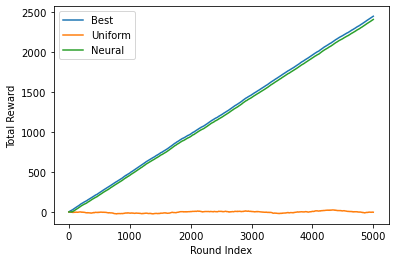

In [10]:
import matplotlib.pyplot as plt
h_r_b = bestagent.history_reward
plt.plot(range(0, T), np.cumsum(h_r_b))

h_r_u = uniformagent.history_reward
plt.plot(range(0, T), np.cumsum(h_r_u))

h_r_n = neuralagent.history_reward
plt.plot(range(0, T), np.cumsum(h_r_n))

plt.legend(["Best", "Uniform", "Neural"])
# plt.legend(["Best", "Uniform"])
plt.xlabel("Round Index")
plt.ylabel("Total Reward")

Text(0.5, 1.0, 'The ratio of reward')

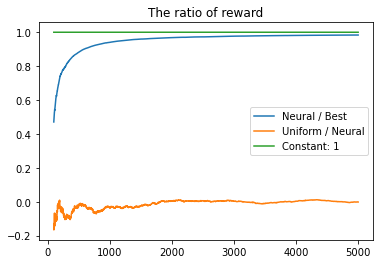

In [11]:
plt.plot(range(100, T), np.cumsum(h_r_n)[100:T] / np.cumsum(h_r_b)[100:T])
plt.plot(range(100, T), np.cumsum(h_r_u)[100:T] / np.cumsum(h_r_n)[100:T])
plt.plot(range(100, T), np.ones(T)[100:T])
plt.legend(["Neural / Best", "Uniform / Neural", "Constant: 1"])
plt.title("The ratio of reward")

We can see that ratio of neural reward over best reward would converge to 1

Text(0.5, 1.0, 'The ratio of of adopting same decision')

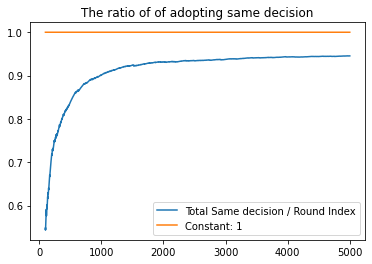

In [12]:
action_match = np.cumsum(neuralagent.history_action == bestagent.history_action)
action_match_ratio = action_match / np.array(range(1, T + 1))
plt.plot(range(100, T), action_match_ratio[100:T])
plt.plot(range(100, T), np.ones(T)[100:T])
plt.legend(["Total Same decision / Round Index", "Constant: 1"])
plt.title("The ratio of of adopting same decision")

In [14]:
np.cumsum(h_r_n)[-10:] / np.cumsum(h_r_b)[-10:]

array([0.98358622, 0.98359043, 0.98359464, 0.98359635, 0.98359681,
       0.98360051, 0.98360536, 0.98361025, 0.98361446, 0.98361976])